## Production-ready Retrieval-Augmented Generation (RAG) Application using Azure OpenAI & LangChain.

##### Designed and implemented a production-ready RAG application using LangChain, Azure Search, Azure Storage, and Azure OpenAI.

### Approach:
###### Using Retrieval-Augmented Generation (RAG) to combine Azure Search for efficient document retrieval, Azure Storage for hosting resources, and Microsoft Foundry, Azure OpenAI for generating coherent answers.

###### Building Retrieval-Augmented Generation (RAG) applications with LangChain provides a powerful and scalable approach to creating intelligent systems that combine retrieval of relevant information with natural language generation.
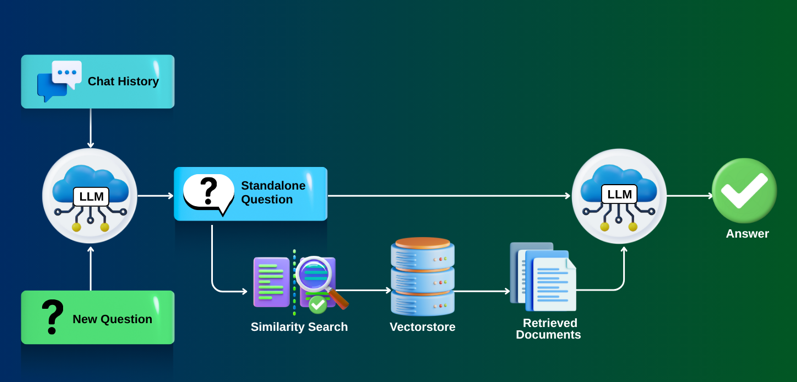

## Install the necessary libraries

In [ ]:
!pip install --upgrade --quiet langchain langchain-community langchain-openai langchain-core beautifulsoup4 requests==2.32.4

##### Azure OpenAI service, GPT-4 model

In [ ]:
## This code is initializing a connection to an Azure OpenAI Service instance and setting up a large language model (LLM) for use in applications

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint='azure_endpoint/',
    azure_deployment='gpt-4o',
    api_key='api_key',
    openai_api_version='2025-01-01-preview',

)


## Grabbing information from a web page using web base loader.

In [ ]:
import bs4
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Load, chunk, and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
   web_paths=("https://www.geeksforgeeks.org/artificial-intelligence/what-is-generative-ai/",),
   # web_paths=("https://k21academy.com/ai-ml/azure/create-azure-openai-service-resources-using-console-cli-step-by-step-activity-guide/",),
   bs_kwargs=dict(
       parse_only=bs4.SoupStrainer(
           class_=("post-content", "post-title", "post-header")
       )
   ),
)

In [ ]:
import os
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"

In [ ]:
docs = loader.load()
docs

[Document(metadata={'source': 'https://www.geeksforgeeks.org/artificial-intelligence/what-is-generative-ai/'}, page_content='')]

In [ ]:
doc = loader.load()
len(docs)

1

In [ ]:
doc

[Document(metadata={'source': 'https://www.geeksforgeeks.org/artificial-intelligence/what-is-generative-ai/'}, page_content='')]

# Embedding Model

In [ ]:
## Model text-embedding-3 large model
from langchain_openai import AzureOpenAIEmbeddings

embedding = AzureOpenAIEmbeddings(
    model="text-embedding-3-large",
    azure_endpoint='azure_endpoint/', #If not provided, will read env variable AZURE_OPENAI_ENDPOINT
    api_key= 'api_key',
    openai_api_version='2023-05-15',
)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=embedding
)

## Retriever

In [ ]:
retriever = vectorstore.as_retriever()

In [ ]:
len(splits)

0

##  Incorporate the retriever into a question-answering chain.

In [ ]:
# Systems prompt
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)


In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [ ]:
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
response = rag_chain.invoke({"input": "What is Generative AI?"})
response["answer"]

'Generative AI refers to artificial intelligence systems designed to create new content, such as text, images, music, or videos, based on patterns and examples from training data. It uses models like neural networks to generate outputs that resemble human-created work. Popular examples include ChatGPT and DALL·E.'

## Install Gradio

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

iface = gr.Interface(
    fn=rag_function,
    inputs=[gr.Textbox(label="Enter URL"), gr.Textbox(label="Ask a question")],
    outputs=gr.Textbox(label="Answer"),
    title="RAG Chatbot with Web Content",
    description="Enter a URL and ask a question about its content.",
)

iface.launch(debug=False)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fe781a231b839deca8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def rag_function(url: str, question: str) -> str:
    """
    Encapsulates the RAG logic to answer questions based on content from a given URL.

    Args:
        url (str): The URL of the web page to load.
        question (str): The user's question.

    Returns:
        str: The answer generated by the RAG chain.
    """
    # 1. Initialize WebBaseLoader with the provided URL
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header")
            )
        ),
    )

    # 2. Load the documents from the WebBaseLoader
    docs = loader.load()

    # 3. Initialize a RecursiveCharacterTextSplitter
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

    # 4. Split the loaded documents into chunks
    splits = text_splitter.split_documents(docs)

    # 5. Create an InMemoryVectorStore from these document chunks
    vectorstore = InMemoryVectorStore.from_documents(
        documents=splits, embedding=embedding
    )

    # 6. Convert the vectorstore into a retriever
    retriever = vectorstore.as_retriever()

    # 7. Recreate the question_answer_chain
    question_answer_chain = create_stuff_documents_chain(llm, prompt)

    # 8. Recreate the rag_chain
    rag_chain = create_retrieval_chain(retriever, question_answer_chain)

    # 9. Invoke the rag_chain with the user's question
    response = rag_chain.invoke({"input": question})

    # 10. Return the answer
    return response["answer"]

print("rag_function defined successfully.")

rag_function defined successfully.


# Task
Create a Gradio interface for a Retrieval Augmented Generation (RAG) chatbot. The interface should take a URL and a user question as input, use the URL to load and process documents, set up a vector store and retriever, and then answer the question using the RAG chain, displaying the answer in a text output.

## Define Gradio RAG function

### Subtask:
Create a Python function that encapsulates the RAG logic, taking a URL and a question as input, and returning the answer.


**Reasoning**:
The subtask is to define a Python function `rag_function` that encapsulates the RAG logic. I will create a `code_block` to define this function, incorporating all the steps outlined in the instructions.



In [ ]:
def rag_function(url: str, question: str) -> str:
    """
    Encapsulates the RAG logic to answer questions based on content from a given URL.

    Args:
        url (str): The URL of the web page to load.
        question (str): The user's question.

    Returns:
        str: The answer generated by the RAG chain.
    """
    # 1. Initialize WebBaseLoader with the provided URL
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header")
            )
        ),
    )

    # 2. Load the documents from the WebBaseLoader
    docs = loader.load()

    # 3. Initialize a RecursiveCharacterTextSplitter
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

    # 4. Split the loaded documents into chunks
    splits = text_splitter.split_documents(docs)

    # 5. Create an InMemoryVectorStore from these document chunks
    vectorstore = InMemoryVectorStore.from_documents(
        documents=splits, embedding=embedding
    )

    # 6. Convert the vectorstore into a retriever
    retriever = vectorstore.as_retriever()

    # 7. Recreate the question_answer_chain
    question_answer_chain = create_stuff_documents_chain(llm, prompt)

    # 8. Recreate the rag_chain
    rag_chain = create_retrieval_chain(retriever, question_answer_chain)

    # 9. Invoke the rag_chain with the user's question
    response = rag_chain.invoke({"input": question})

    # 10. Return the answer
    return response["answer"]

print("rag_function defined successfully.")

rag_function defined successfully.


## Create and launch Gradio interface

### Subtask:
Set up a Gradio interface with two text input components for the URL and the user's question, and one text output component for the RAG chain's answer. The `fn` parameter of the Gradio interface will point to the RAG function created in the previous step. Finally, launch the Gradio application.


## Summary:

### Data Analysis Key Findings

*   A Python function named `rag_function` was successfully defined to encapsulate the entire Retrieval Augmented Generation (RAG) logic.
*   This function takes a URL and a user question as input and is designed to return an answer.
*   The `rag_function` implements the following steps:
    *   It initializes a `WebBaseLoader` to load documents from the provided URL, specifically parsing elements with classes "post-content", "post-title", and "post-header".
    *   Documents are then split into chunks using a `RecursiveCharacterTextSplitter` with a `chunk_size` of 1000 characters and a `chunk_overlap` of 200 characters.
    *   An `InMemoryVectorStore` is created from these document chunks using a predefined `embedding` object, and then converted into a `retriever`.
    *   A `question_answer_chain` and a `rag_chain` are constructed using the `retriever` and previously defined `llm` and `prompt` objects.
    *   Finally, the `rag_chain` is invoked with the user's question, and the extracted answer is returned.

### Insights or Next Steps

*   The `rag_function` is now prepared and can be directly used as the backend logic for the Gradio interface, fulfilling the core RAG processing requirement.
*   The next logical step is to create the Gradio interface, connecting its input components (for URL and question) to the `rag_function` and displaying the output.
